<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification to detect sensitive data exposure

## Importing libraries and downloading the dataset

In [150]:
# Importing the necessary libraries
import tensorflow as tf
import json
import os
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

"""
# Downloading the dataset
git_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images.git

dataset_folder = git_folder + "/text_dataset/"
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"
"""

'\n# Downloading the dataset\ngit_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"\nif os.path.exists(git_folder) == False:\n  !git clone https://github.com/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images.git\n\ndataset_folder = git_folder + "/text_dataset/"\nsensitive_datafile = "SensitiveDataset.json"\nnonsensitive_datafile = "NonSensitiveDataset.json"\n'

In [151]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

## Preprocessing the dataset

In [152]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in  sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")
import pandas as pd
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])
df= pd.concat([sen, nonsen], axis=0)
df=df.sample(frac=1).reset_index(drop=True)
df_sen=df[df['labels']==1]
df_non=df[df['labels']==0]
df_non_downsampled = df_non.sample(10000)
df_sen_downsampled=df_sen.sample(10000)
df_balanced = pd.concat([df_non_downsampled, df_sen_downsampled])
# Splitting into features (X) and labels (y)
X = df_balanced['sentences'].values
y = df_balanced['labels'].values
training_sentences, validation_sentences, training_labels, validation_labels= train_test_split(X,y,test_size=0.2,stratify=y)

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences)
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences)

Training Dataset Size:  16000
Sample Training Data: ['card no:4073 8570 3877 6074, expiry month:aug-26, card holder name:ramaiyan  settu, cvv:126'
 "An agent unspecified foreign power (John Miljan) plots take California confusion American Civil War. He uses Morrell Overland Raiders prevent news reaching east. The Raiders rustle stagecoach Pony Express horses various relay stations cut lines communication east. Bill Hickok sent one relay stations hopes able keep ponies raiders. Calamity Gabby, horse traders relay stations, ride Indian helpers just Bill finishes off last Raiders attacked post. Bill severely hurt Calamity Gabby stick around while.\nDuring time, Bill’s old fiancée, Louise Mason, shows up. She wants make breaking engagement support Confederacy Bil's North. They agree forget war; Bill soon planning wedding. However, Marshal Evans, head communication lines, wants Bill take shipment gold east support Federal war effort.\nBill knows it’s dangerous actually take himself, raiders

In [153]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)
# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))
with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")
# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 91000
Saving the word index as JSON


In [154]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [155]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting\"
"""
DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
"""
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Global average pooling operation (Flattening)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 60, 32)            96000     
                                                                 
 batch_normalization_21 (Ba  (None, 60, 32)            128       
 tchNormalization)                                               
                                                                 
 conv1d_7 (Conv1D)           (None, 58, 32)            3104      
                                                                 
 dropout_8 (Dropout)         (None, 58, 32)            0         
                                                                 
 batch_normalization_22 (Ba  (None, 58, 32)            128       
 tchNormalization)                                               
                                                                 
 global_average_pooling1d_7  (None, 32)               

## Training

In [156]:
num_epochs = 5

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/5
500/500 [==============================] - 6s 8ms/step - loss: 0.2823 - accuracy: 0.9641 - val_loss: 0.3948 - val_accuracy: 0.8685
Epoch 2/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0726 - accuracy: 0.9984 - val_loss: 0.0255 - val_accuracy: 0.9995
Epoch 3/5
500/500 [==============================] - 4s 7ms/step - loss: 0.0438 - accuracy: 0.9988 - val_loss: 0.0136 - val_accuracy: 0.9995
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0322 - accuracy: 0.9986 - val_loss: 0.0096 - val_accuracy: 0.9995
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0258 - accuracy: 0.9994 - val_loss: 0.0092 - val_accuracy: 0.9992


## Plotting Accuracy and Loss Functions

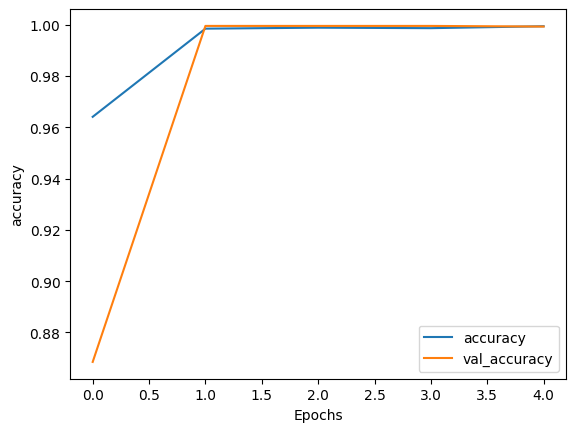

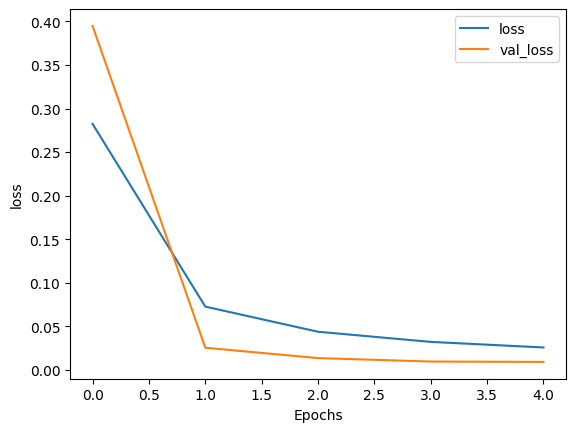

In [157]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

Confusion Matrix
125/125 [==============================] - 0s 2ms/step
Threshold [0.50000244]
Accuracy for Test Data =  99.925


Text(95.72222222222221, 0.5, 'Expected')

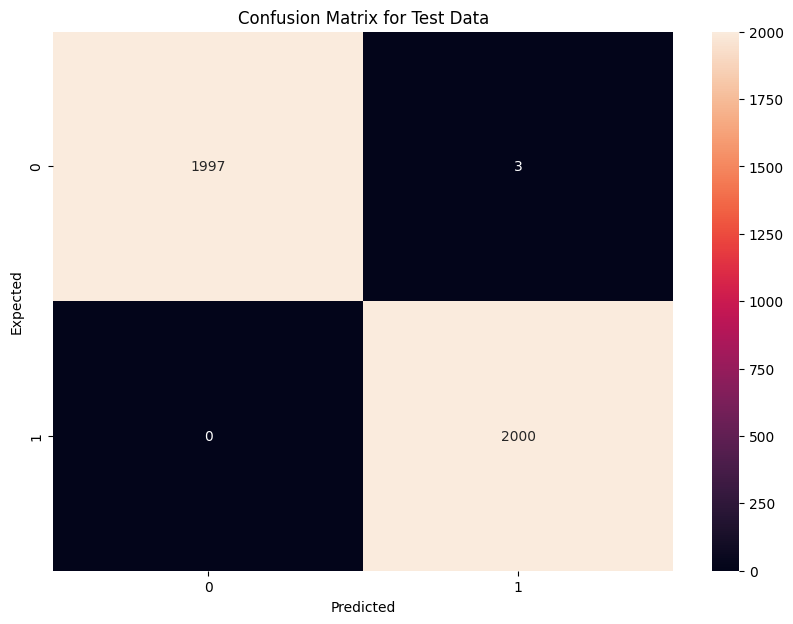

In [158]:
import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
print("Threshold",(min(y_predicted)+max(y_predicted))/2)
y_predicted_labels = y_predicted > 0.5
#print(y_predicted_labels)
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )
"""
for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  """
cm = tf.math.confusion_matrix(validation_labels,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [159]:
from sklearn.metrics import classification_report,accuracy_score
report = classification_report(validation_labels,y_predicted_labels)
#print("Classification Report:\n", report)
print("Accuracy Score:", accuracy_score(validation_labels,y_predicted_labels)*100)

Accuracy Score: 99.925


## Sample Example

In [160]:
# Sample examples
sentence = ['Sr No', ' Blood Bank Name', ' State', ' District', ' City', ' Address',             
       'Pincode', ' Contact No', 'phone', ' Helpline', ' Fax', ' Email',                 
       ' Website', ' Nodal Officer ', ' Contact Nodal Officer',                   
       ' Mobile Nodal Officer', ' Email Nodal Officer',                              
       ' Qualification Nodal Officer', ' Category',                                       
       ' Blood Component Available', ' Apheresis', ' Service Time',                             
       ' License #', ' Date License Obtained', ' Date of Renewal', ' Latitude',                   
       ' Longitude']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.88:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

1/1 [==============================] - 0s 86ms/step
0.9506702
Sensitive - Sr No
0.998779
Sensitive -  Blood Bank Name
0.887015
Sensitive -  State
0.8727274
Non-Sensitive -  District
0.8656015
Non-Sensitive -  City
0.8714122
Non-Sensitive -  Address
0.9014691
Sensitive - Pincode
0.9577206
Sensitive -  Contact No
0.96666366
Sensitive - phone
0.9014691
Sensitive -  Helpline
0.9014691
Sensitive -  Fax
0.9451342
Sensitive -  Email
0.9014691
Sensitive -  Website
0.86192554
Non-Sensitive -  Nodal Officer 
0.8441931
Non-Sensitive -  Contact Nodal Officer
0.82856035
Non-Sensitive -  Mobile Nodal Officer
0.90866494
Sensitive -  Email Nodal Officer
0.82856035
Non-Sensitive -  Qualification Nodal Officer
0.9014691
Sensitive -  Category
0.8508784
Non-Sensitive -  Blood Component Available
0.9014691
Sensitive -  Apheresis
0.8567828
Non-Sensitive -  Service Time
0.9014691
Sensitive -  License #
0.88430804
Sensitive -  Date License Obtained
0.8996585
Sensitive -  Date of Renewal
0.9014691
Sensitive - 

In [161]:
df=pd.read_csv('blood-banks.csv',encoding='latin1')
#identify sensitive columns
sensitive_columns = []
for i in range(len(predictions)):
  if predictions[i][0]>0.88:
    sensitive_columns.append(df.columns[i])
print(sensitive_columns)
#implemt any encryption technique to protect the sensitive data
#save the model
model.save('model.h5')
print("Model Saved")


['Sr No', ' Blood Bank Name', ' State', 'Pincode', ' Contact No', ' Mobile', ' Helpline', ' Fax', ' Email', ' Website', ' Email Nodal Officer', ' Category', ' Apheresis', ' License #', ' Date License Obtained', ' Date of Renewal', ' Latitude', ' Longitude']
Model Saved


c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [162]:
from cryptography.fernet import Fernet

df_sen = df[sensitive_columns]
df_sen.to_csv('sensitive_data.csv',index=False)
df_sen = pd.read_csv('sensitive_data.csv')
# Generate a key
key = Fernet.generate_key()

# Save the key to a file
with open("key.key", "wb") as key_file:
    key_file.write(key)

# Load the key from the file
with open("key.key", "rb") as key_file:
    key = key_file.read()

# Create a cipher suite
cipher_suite = Fernet(key)

# Encrypt the data
cipher_text = cipher_suite.encrypt(df_sen.to_csv().encode())

# Save the encrypted data to a file
with open("blood-banks.csv.encrypted", "wb") as file:
    file.write(cipher_text)
print("Data Encrypted and Saved")

# Load the encrypted data from the file
with open("blood-banks.csv.encrypted", "rb") as file:
    cipher_text = file.read()

# Decrypt the data
plain_text = cipher_suite.decrypt(cipher_text)

# Save the decrypted data to a file
with open("blood-banks.csv.decrypted", "wb") as file:
    file.write(plain_text)
print("Data Decrypted and Saved")

# Save the model
model.save("model.h5")
print("Model Saved")



Data Encrypted and Saved
Data Decrypted and Saved
Model Saved


c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
"""
import re
import nltk
from nltk.tokenize import word_tokenize
from tensorflow import keras
from tensorflow.keras.layers import Flatten
# Load the CNN model


# Function to extract sensitive text from a file
def extract_sensitive_text(file_path):
    # Read the file content
    with open(file_path, 'r') as file:
         text = file.read().replace('\n', '')
    words = text.split(' ')

    # Convert words to integer indices
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(words)
    sequences = tokenizer.texts_to_sequences(words)

     # Pad sequences to ensure consistent length
    data = pad_sequences(sequences)

     # Reshape data to 3D for CNN
    data = data.reshape((data.shape[0], data.shape[1], 1))

    model.add(Flatten())
    # Pass the tokenized words to the CNN model for prediction
    predictions = model.predict(data)

    # Identify sensitive data based on the model's predictions
    sensitive_text = [word for word, prediction in zip(words, predictions) if prediction == 1]

    return sensitive_text

# Get user input for the file path
file_path = input("Enter the file path: ")

# Extract sensitive text from the file
sensitive_text = extract_sensitive_text(file_path)

# Print the extracted sensitive text
print("Sensitive Text:")
for word in sensitive_text:
    print(word)
"""

'\nimport re\nimport nltk\nfrom nltk.tokenize import word_tokenize\nfrom tensorflow import keras\nfrom tensorflow.keras.layers import Flatten\n# Load the CNN model\n\n\n# Function to extract sensitive text from a file\ndef extract_sensitive_text(file_path):\n    # Read the file content\n    with open(file_path, \'r\') as file:\n         text = file.read().replace(\'\n\', \'\')\n    words = text.split(\' \')\n\n    # Convert words to integer indices\n    tokenizer = Tokenizer()\n    tokenizer.fit_on_texts(words)\n    sequences = tokenizer.texts_to_sequences(words)\n\n     # Pad sequences to ensure consistent length\n    data = pad_sequences(sequences)\n\n     # Reshape data to 3D for CNN\n    data = data.reshape((data.shape[0], data.shape[1], 1))\n\n    model.add(Flatten())\n    # Pass the tokenized words to the CNN model for prediction\n    predictions = model.predict(data)\n\n    # Identify sensitive data based on the model\'s predictions\n    sensitive_text = [word for word, predicti

In [71]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np

def process_csv(file_path):
    df = pd.read_csv(file_path, encoding='latin1')  # Specify the encoding parameter
    feature_names = df.columns.tolist()
    return feature_names

def process_txt(file_path):
    with open(file_path, 'r', encoding='latin1') as file:  # Specify the encoding parameter
        text = file.read()
    tokens = word_tokenize(text)
    return tokens

def process_json(file_path):
    # Add your code to process JSON files here
    pass

def process_file(file_path):
    if file_path.endswith('.csv'):
        feature_names = process_csv(file_path)
        return feature_names
    elif file_path.endswith('.txt'):
        tokens = process_txt(file_path)
        return tokens
    elif file_path.endswith('.json'):
        # Add your code to process JSON files here
        pass
    else:
        print("Unsupported file format.")

# Get the file path from the user
file_path = input("Enter the path of the file: ")

# Process the file
features = process_file(file_path)

# Pass the features as input for the model

# Convert the list to a numpy array
data_array = np.array(features)

# Reshape the array to match the input shape expected by the model
data_input = data_array.reshape(1, -1)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)

# Encoding
sequences = tokenizer.texts_to_sequences(features)

# Find the length of the longest sequence
max_length = max(len(sequence) for sequence in sequences)

data_input = pad_sequences(sequences, maxlen=max_length)

# Make predictions using the model
preds = model.predict(data_input)

# Print the predictions
print(preds)

for i in range(len(preds)):
  print(preds[i][0])
  if preds[i][0]>0.88:
    print("Sensitive - "+ features[i])
  else:
    print("Non-Sensitive - " + features[i] )

1/1 [==============================] - 0s 150ms/step
[[9.9993145e-01]
 [1.5967459e-03]
 [6.2404603e-01]
 [5.2909993e-02]
 [9.9999613e-01]
 [3.5937645e-10]
 [8.7958264e-01]
 [9.6779609e-01]
 [2.5625437e-01]
 [1.0000000e+00]
 [9.9999118e-01]
 [9.9205548e-01]
 [3.9321694e-01]
 [8.8759899e-01]
 [3.1213811e-01]]
0.99993145
Sensitive - Name
0.0015967459
Non-Sensitive - Age
0.624046
Non-Sensitive - Gender
0.052909993
Non-Sensitive - Blood Type
0.9999961
Sensitive - Medical Condition
3.5937645e-10
Non-Sensitive - Date of Admission
0.87958264
Non-Sensitive - Doctor
0.9677961
Sensitive - Hospital
0.25625437
Non-Sensitive - Insurance Provider
1.0
Sensitive - Billing Amount
0.9999912
Sensitive - Room Number
0.9920555
Sensitive - Admission Type
0.39321694
Non-Sensitive - Discharge Date
0.887599
Sensitive - Medication
0.3121381
Non-Sensitive - Test Results


Healthcare dataset

In [95]:
df=pd.read_csv('healthcare_dataset.csv')
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


In [96]:
# make name,age,medical condition,doctor,hospital,medication,test results as sensitive
# make remaining as non-sensitive
df.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

In [97]:
import pandas as pd
import json

# Assuming df is your DataFrame
sensitive_columns = ['Name', 'Age', 'Medical Condition', 'Doctor', 'Hospital', 'Medication', 'Test Results','Billing Amount']

json_list = []

for _, row in df.iterrows():
    data_str = ', '.join(f'{column}:{row[column]}' for column in sensitive_columns)
    json_list.append({"is_sensitive": 1, "data": data_str})

# Save to JSON file
with open('data.json', 'w') as f:
    json.dump(json_list, f)

In [98]:
non_sensitive_columns = [col for col in df.columns if col not in sensitive_columns]

json_list = []

for _, row in df.iterrows():
    data_str = ', '.join(f'{column}:{row[column]}' for column in non_sensitive_columns)
    json_list.append({"is_sensitive": 0, "data": data_str})

# Save to JSON file
with open('non_sensitive_data.json', 'w') as f:
    json.dump(json_list, f)

In [99]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    d.append([sentence,label])
  return d

In [100]:
# Load sensitive and non-sensitive data from JSON files
sen = loadDataset('data.json')
nonsen = loadDataset('non_sensitive_data.json')

In [101]:
print(len(sen))
print(len(nonsen))

10000
10000


In [103]:
import pandas as pd
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])
df= pd.concat([sen, nonsen], axis=0)
df=df.sample(frac=1).reset_index(drop=True)
df_sen=df[df['labels']==1]
df_non=df[df['labels']==0]
df_balanced = pd.concat([df_non, df_sen])

# Splitting into features (X) and labels (y)
X = df_balanced['sentences'].values
y = df_balanced['labels'].values

training_sentences, validation_sentences, training_labels, validation_labels= train_test_split(X,y,test_size=0.2,stratify=y)

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences)
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences)

Training Dataset Size:  16000
Sample Training Data: ['Name:Joseph Martin PhD, Age:47, Medical Condition:Cancer, Doctor:Sean Young, Hospital:Logan-Stewart, Medication:Aspirin, Test Results:Inconclusive, Billing Amount:8197.310249862994'
 'Name:Jessica Perez, Age:40, Medical Condition:Arthritis, Doctor:Theresa Moore, Hospital:Blackwell, Aguilar Hughes, Medication:Paracetamol, Test Results:Abnormal, Billing Amount:6164.281923358486'
 'Gender:Male, Blood Type:A-, Date Admission:2020-06-05, Insurance Provider:UnitedHealthcare, Room Number:466, Admission Type:Emergency, Discharge Date:2020-06-11'
 ...
 'Name:Jeffrey Gregory, Age:78, Medical Condition:Asthma, Doctor:Dwayne Walker, Hospital:Mejia-Harris, Medication:Ibuprofen, Test Results:Inconclusive, Billing Amount:28623.423800404795'
 'Gender:Female, Blood Type:AB-, Date Admission:2022-02-11, Insurance Provider:Cigna, Room Number:427, Admission Type:Elective, Discharge Date:2022-02-17'
 'Gender:Male, Blood Type:O+, Date Admission:2021-02-12

In [104]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 17510
Saving the word index as JSON


In [105]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting\"

DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    # Global average pooling operation (Flattening)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.0001)),
    #tf.keras.layers.Dropout(0.5),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 32)            96000     
                                                                 
 batch_normalization_12 (Ba  (None, 60, 32)            128       
 tchNormalization)                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 58, 32)            3104      
                                                                 
 batch_normalization_13 (Ba  (None, 58, 32)            128       
 tchNormalization)                                               
                                                                 
 global_average_pooling1d_4  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                      

In [106]:
num_epochs = 5

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1,)
               # callbacks=[callbacks])

Epoch 1/5
500/500 [==============================] - 5s 6ms/step - loss: 0.0111 - accuracy: 0.9984 - val_loss: 0.1279 - val_accuracy: 1.0000
Epoch 2/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/5
500/500 [==============================] - 4s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000


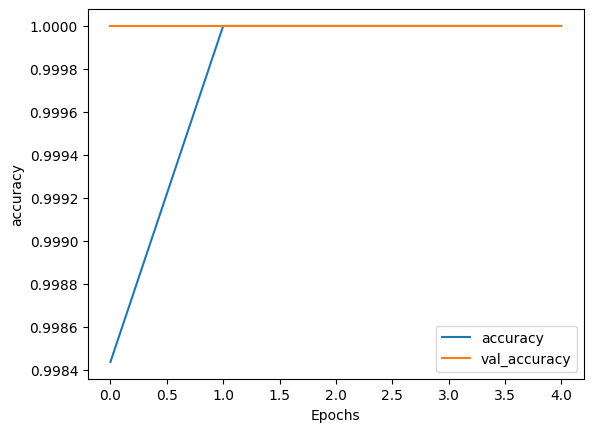

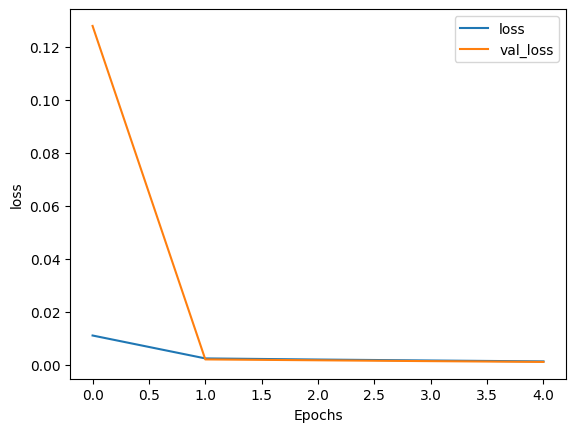

In [107]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
125/125 [==============================] - 1s 3ms/step
Threshold [0.5000004]
Accuracy for Test Data =  100.0


Text(95.72222222222221, 0.5, 'Expected')

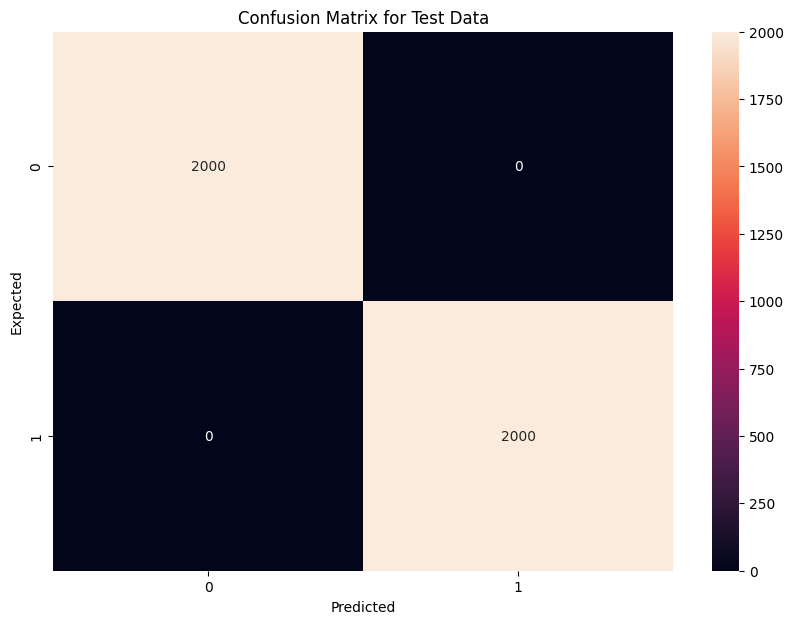

In [108]:
import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
print("Threshold",(min(y_predicted)+max(y_predicted))/2)
y_predicted_labels = y_predicted > 0.5
#print(y_predicted_labels)
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )
"""
for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  """
cm = tf.math.confusion_matrix(validation_labels,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [87]:
"""
from tensorflow.keras.losses import BinaryCrossentropy
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

optimizer = optimizers.Adam(learning_rate=5e-5)
loss = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#texts creation
texts = ["Sr No Blood Bank Name State District City Address Pincode Contact No phone Helpline Fax Email Website Nodal Officer Contact Nodal Officer Mobile Nodal Officer Email Nodal Officer Qualification Nodal Officer Category Blood Component Available Apheresis Service Time License # Date License Obtained Date of Renewal Latitude Longitude"]

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='tf')
outputs = model(inputs)
"""

'\nfrom tensorflow.keras.losses import BinaryCrossentropy\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nmodel = TFBertForSequenceClassification.from_pretrained(\'bert-base-uncased\', num_labels=2)\n\noptimizer = optimizers.Adam(learning_rate=5e-5)\nloss = BinaryCrossentropy(from_logits=True)\nmodel.compile(optimizer=optimizer, loss=loss, metrics=[\'accuracy\'])\n\n#texts creation\ntexts = ["Sr No Blood Bank Name State District City Address Pincode Contact No phone Helpline Fax Email Website Nodal Officer Contact Nodal Officer Mobile Nodal Officer Email Nodal Officer Qualification Nodal Officer Category Blood Component Available Apheresis Service Time License # Date License Obtained Date of Renewal Latitude Longitude"]\n\ninputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors=\'tf\')\noutputs = model(inputs)\n'

In [88]:
"""
from rasa_nlu.model import Interpreter
import json

interpreter = Interpreter.load("./models/current/nlu")
messages = ["the password could be bananas", "username foo, password: Zzzsa23", "the weather is just fine"]

for message in messages:
    print("Evaluating: %s" % message)
    result = interpreter.parse(message)
    print("Most likely intent: %s" % result['intent'])
    print("all data: %s" % json.dumps(result, indent=2))
"""

'\nfrom rasa_nlu.model import Interpreter\nimport json\n\ninterpreter = Interpreter.load("./models/current/nlu")\nmessages = ["the password could be bananas", "username foo, password: Zzzsa23", "the weather is just fine"]\n\nfor message in messages:\n    print("Evaluating: %s" % message)\n    result = interpreter.parse(message)\n    print("Most likely intent: %s" % result[\'intent\'])\n    print("all data: %s" % json.dumps(result, indent=2))\n'

In [89]:
"""
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(training_padded, training_labels, epochs=2, batch_size = 32)
y_predicted = model.predict(validation_padded)
y_predicted = y_predicted.flatten()
print(y_predicted)
"""

'\nimport tensorflow as tf\nimport tensorflow_hub as hub\n!pip install tensorflow-text\nimport tensorflow_text as text\nbert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")\nbert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")\n# Bert layers\ntext_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=\'text\')\npreprocessed_text = bert_preprocess(text_input)\noutputs = bert_encoder(preprocessed_text)\n# Neural network layers\nl = tf.keras.layers.Dropout(0.1, name="dropout")(outputs[\'pooled_output\'])\nl = tf.keras.layers.Dense(1, activation=\'sigmoid\', name="output")(l)\n# Use inputs and outputs to construct a final model\nmodel = tf.keras.Model(inputs=[text_input], outputs = [l])\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\nmodel.fit(training_padded, training_labels, epochs=2, batch_size = 32)\ny_predicted = model.predict(validation_padded)\ny_pred